In [43]:
import scipy.stats as stats
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
import random
import sys
import corner
import pystan
from statsmodels.graphics.tsaplots import plot_acf
import seaborn as sns
import pandas as pd

np.random.seed(1234)

# Direct Sampling Methods

In [ ]:
# We start by giving some examples of direct sampling methods. We will reproduce the examples from the lectures.

# Method of Inversion

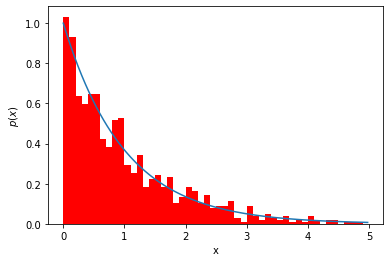

In [3]:
# Samples from an exponential distribution with rate parameter
rate=1.0
nsamp=1000
usamples=np.random.uniform(0.0,1.0,nsamp)
samples=np.log(1.0/(1.0-usamples))/rate
xvs=np.arange(0.,5./rate,step=0.02)
histxs=np.arange(0,5./rate,step=100./(rate*nsamp))
counts,edges,patches=plt.hist(samples,bins=histxs,color="red",density=True)
plt.xlabel('x')
plt.ylabel('$p(x)$')
y=stats.expon.pdf(xvs, 0.0, 1.0/rate)
plt.plot(xvs, y)
plt.savefig("MethodOfInversionExample.pdf")

# Rejection Sampling

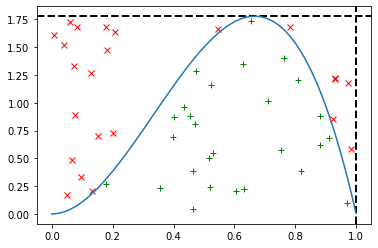

In [4]:
# We want to draw samples from a Beta(3,2) distribution using sampling in a rectangular box. The box height is M = 16/9.
nsamp=50
M=16.0/9.0
thsamples=np.random.uniform(0.0,1.0,nsamp)
ysamples=np.random.uniform(0.0,M,nsamp)

accids=ysamples < stats.beta.pdf(thsamples,3.,2.)
rejids=ysamples > stats.beta.pdf(thsamples,3.,2.)

xvs=np.arange(0.,1.,step=0.001)
pdftrue=stats.beta.pdf(xvs,3.,2.)

plt.plot(thsamples[accids],ysamples[accids],'g+')
plt.plot(thsamples[rejids],ysamples[rejids],'rx')
plt.axhline(M, color='black', lw=2, linestyle='--',label='max')
plt.axvline(1, color='black', lw=2, linestyle='--',label='')
plt.plot(xvs, pdftrue)

plt.savefig("RejectionSamplingBoxExample.pdf")

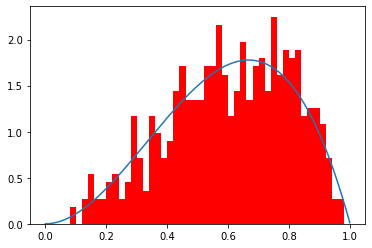

In [5]:
# Now generate more samples and check that we get the right distribution
nsamp=1000
thsamples=np.random.uniform(0.0,1.0,nsamp)
ysamples=np.random.uniform(0.0,M,nsamp)

accids=ysamples < stats.beta.pdf(thsamples,3.,2.)
rejids=ysamples > stats.beta.pdf(thsamples,3.,2.)
accepted=thsamples[accids]

histxs=np.arange(0,1.,step=0.02)
counts,edges,patches=plt.hist(accepted,bins=histxs,color="red",density=True)
plt.plot(xvs, pdftrue)

plt.savefig("RejectionSamplingBoxExample_Histogram.pdf")

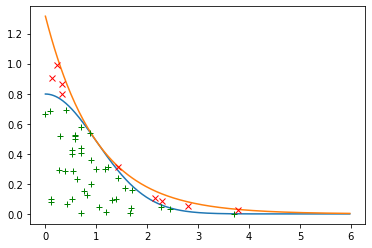

In [6]:
# We want to draw samples from a half-Normal distribution. Instead we draw samples from an expoential distribution
# with parameter 1. We set the scaling M = sqrt(2/pi)*exp(0.5) (EXERCISE).

# First compare half-Normal distribution to M g(theta)
xvs=np.arange(0.,6.,step=0.02)
M=np.sqrt(2/np.pi)*np.exp(0.5)
yhalfnorm=2.0*stats.norm.pdf(xvs,0.,1.)
yexponential=M*stats.expon.pdf(xvs, 0.0, 1.0)
plt.plot(xvs, yhalfnorm)
plt.plot(xvs,yexponential)

# Now draw samples from exponential distribution using method of inversion 
nsamp=50
usamples=np.random.uniform(0.0,1.0,nsamp)
samples=np.log(1.0/(1.0-usamples))

# Identify accepted and rejected samples
vsamples=np.random.uniform(0.0,1.0,nsamp)
accids=vsamples < 2.0*stats.norm.pdf(samples,0.,1.)/(M*stats.expon.pdf(samples))
rejids=vsamples > 2.0*stats.norm.pdf(samples,0.,1.)/(M*stats.expon.pdf(samples))
accepted=samples[accids]
rejected=samples[rejids]

accy=M*stats.expon.pdf(samples[accids])*vsamples[accids]
rejy=M*stats.expon.pdf(samples[rejids])*vsamples[rejids]

plt.plot(accepted,accy,'g+')
plt.plot(rejected,rejy,'rx')
plt.savefig("RejectionSamplingExample.pdf")


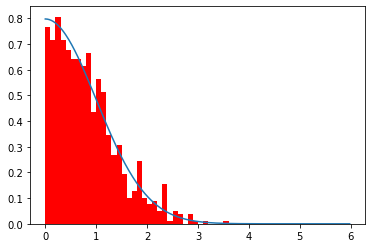

In [7]:
# Now generate 1000 samples and plot histogram
nsamp=1000
usamples=np.random.uniform(0.0,1.0,nsamp)
samples=np.log(1.0/(1.0-usamples))

# Identify accepted and rejected samples
vsamples=np.random.uniform(0.0,1.0,nsamp)
accids=vsamples < 2.0*stats.norm.pdf(samples,0.,1.)/(M*stats.expon.pdf(samples))
accepted=samples[accids]

histxs=np.arange(0,6.,step=0.1)
counts,edges,patches=plt.hist(accepted,bins=histxs,color="red",density=True)
plt.plot(xvs, yhalfnorm)

plt.savefig("RejectionSamplingExample_Histogram.pdf")

# Importance Sampling

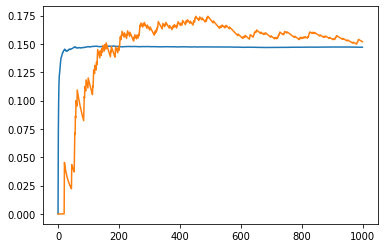

In [8]:
# Generate samples iusing g(x)=2/x^2 for x > 2
nsamp=1000
usamples=np.random.uniform(0.0,1.0,nsamp)
samples=2.0/usamples

# Compute importance weights
weights=samples**2/(2.0*np.pi*(1.0+samples**2))

# Compute running average of weight above 2
ImpRunav=np.zeros(nsamp)
for i in range(nsamp):
    ImpRunav[i]=sum(weights[0:i])/(i+1.0)
xvs=np.arange(0,nsamp,1)
plt.plot(xvs,ImpRunav)

# Directly sample from Cauchy distribution and produce same running average
directsamples=np.random.standard_cauchy(nsamp)
DirRunav=np.zeros(nsamp)
for i in range(nsamp):
    thisset=directsamples[0:i]
    DirRunav[i]=len(thisset[thisset>2.0])/(i+1.0)
plt.plot(xvs,DirRunav)
plt.savefig("ImportanceSamplingExample.pdf")

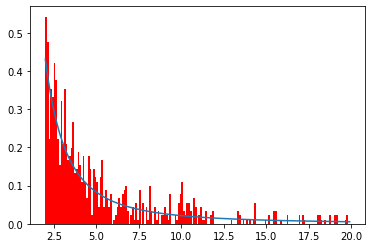

In [9]:
normweights=weights/sum(weights)
resample=np.random.choice(samples,nsamp,p=normweights)
histxs=np.arange(2.0,20.,step=0.1)
counts,edges,patches=plt.hist(resample,bins=histxs,color="red",density=True)
yvs=stats.cauchy.pdf(histxs,0.,1.)/(1.-stats.cauchy.cdf(2.0,0.,1.))
plt.plot(histxs,yvs)
plt.savefig("SIRExample.pdf")

# Model sampling with pystan

In [10]:
# Now we give an example of Bayesian posterior sampling using pystan. First we need some data. Here we will use the
# mtcars data set that we used i lectures. It is deifned in the mtcars_proc.csv data set you can download from the
# course website. 

In [5]:
datatable = np.genfromtxt("mtcars_proc.csv",names=True,delimiter=",")

In [2]:
# There are two ways to define models using pystan. One approach is to have a separate model definition file, 
# which we load as follows.
lin_model = pystan.StanModel(file='linear_model_mtcars.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bb7828d1cd907e9c695110ffe17b1470 NOW.


In [8]:
# Alternatively we can define the model directly in python like this
lin_model_def = """
data {
  int npts;
  vector[npts] mpg;
  vector[npts] drat;
  vector[npts] wt;
  vector[npts] qsec;
  real mu0;
  real var0;
  real a;
  real b;
}

parameters {
  real beta0;
  real beta1;
  real beta2;
  real beta3;
  real<lower=0> v;
}

model {
  for (i in 1:npts) {
        target+=normal_lpdf(mpg[i] | beta0+beta1*drat[i]+beta2*wt[i]+beta3*qsec[i],sqrt(v));
  }
  target += normal_lpdf(beta0 | mu0, sqrt(var0));
  target += normal_lpdf(beta1 | mu0, sqrt(var0));
  target += normal_lpdf(beta2 | mu0, sqrt(var0));
  target += normal_lpdf(beta3 | mu0, sqrt(var0));
  target += inv_gamma_lpdf(v | a,b);
}

generated quantities {
  vector[npts] ypred;
  for (i in 1:npts) {
    ypred[i]=normal_rng(beta0+beta1*drat[i]+beta2*wt[i]+beta3*qsec[i], sqrt(v));
  }
}
"""
lin_model = pystan.StanModel(model_code=lin_model_def)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c3de7685b315ce38100c6a463778e634 NOW.


Inference for Stan model: anon_model_c3de7685b315ce38100c6a463778e634.
4 chains, each with iter=1000; warmup=250; thin=1; 
post-warmup draws per chain=750, total post-warmup draws=3000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta0      10.62    0.25   7.75  -4.73   5.31  10.52  15.94  26.15    952    1.0
beta1       1.74    0.03   1.22  -0.71   0.92   1.74   2.57   4.17   1381    1.0
beta2      -4.35    0.02   0.67  -5.65  -4.79  -4.36  -3.91  -2.99   1243    1.0
beta3       0.96  7.0e-3   0.28   0.43   0.78   0.97   1.15   1.49   1575    1.0
v           7.05    0.06   2.04    4.1   5.67   6.68   7.99  12.01   1357    1.0
ypred[1]    21.8    0.05    2.7   16.4  20.02  21.84  23.62  27.06   3018    1.0
ypred[2]   21.33    0.05   2.74  16.14   19.5  21.25  23.08  26.78   2946    1.0
ypred[3]   25.14    0.05   2.76  19.67  23.37  25.13  26.93  30.64   2974    1.0
ypred[4]   20.74    0.05   2.79  15.26  18.83  20.67   22.6  26.13   2920    1.0
ypr

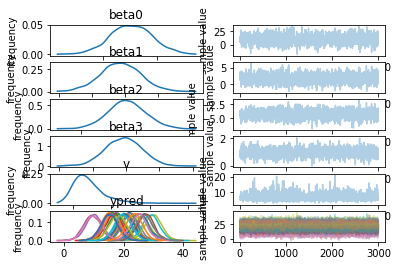

In [6]:
# Specify prior hyperparameters
# Priors on linear model coefficients.
mu0=0.
var0=1000.

# Prior on precision
a=0.1
b=0.1

# Define data array
lin_model_data = {'npts': datatable['mpg'][:].shape[0],
            'mpg': datatable['mpg'][:],
            'drat': datatable['drat'][:],
            'wt': datatable['wt'][:],'qsec': datatable['qsec'][:], 'mu0': mu0, 'var0': var0, 'a': a, 'b': b}


# Now get some samples from the posterior
lin_model_fit = lin_model.sampling(data=lin_model_data, iter=1000, chains=4, warmup=250, thin=1, seed=101)

# Plot results 
lin_model_fit.plot()
# Get summary statistics. Note summary automatically includes estimates of the effective sample size (n_eff) and the Gelman-Rubin 
# convergence diagnostic (Rhat).
lin_model_fit

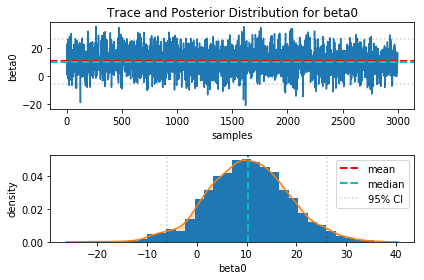

In [6]:
# Extract samples from fit for easier manipulation
summary_dict = lin_model_fit.summary()
lin_model_fit_dataframe = pd.DataFrame(summary_dict['summary'], 
                  columns=summary_dict['summary_colnames'], 
                  index=summary_dict['summary_rownames'])

# Plot trace plot and histogram of posterior samples for parameter 'param'
param='beta0'

cred_min, cred_max = np.percentile(lin_model_fit[param], 2.5), np.percentile(lin_model_fit[param], 97.5)
mean=np.mean(lin_model_fit[param])
median=np.median(lin_model_fit[param])

plt.subplot(2,1,1)
plt.plot(lin_model_fit[param])
plt.xlabel('samples')
plt.ylabel(param)
plt.axhline(mean, color='r', lw=2, linestyle='--')
plt.axhline(median, color='c', lw=2, linestyle='--')
plt.axhline(cred_min, linestyle=':', color='k', alpha=0.2)
plt.axhline(cred_max, linestyle=':', color='k', alpha=0.2)
plt.title('Trace and Posterior Distribution for {}'.format(param))

plt.subplot(2,1,2)
plt.hist(lin_model_fit[param], 30, density=True); sns.kdeplot(lin_model_fit[param], shade=True)
plt.xlabel(param)
plt.ylabel('density')
plt.axvline(mean, color='r', lw=2, linestyle='--',label='mean')
plt.axvline(median, color='c', lw=2, linestyle='--',label='median')
plt.axvline(cred_min, linestyle=':', color='k', alpha=0.2, label='95% CI')
plt.axvline(cred_max, linestyle=':', color='k', alpha=0.2)
  
plt.gcf().tight_layout()
plt.legend()


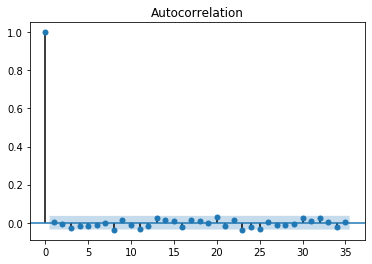

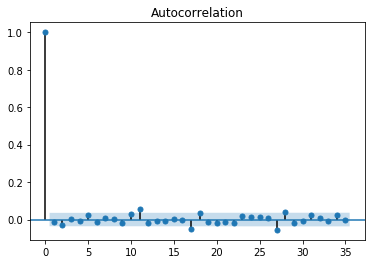

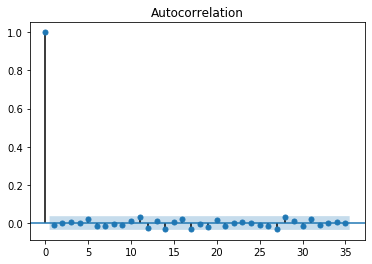

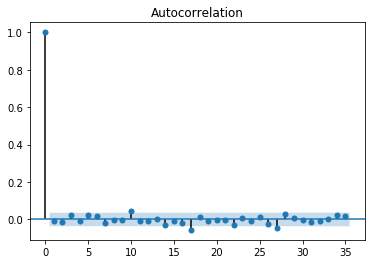

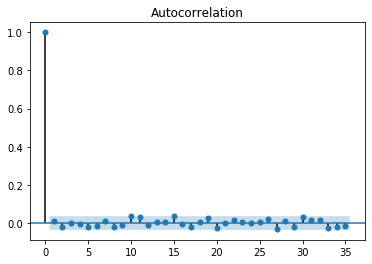

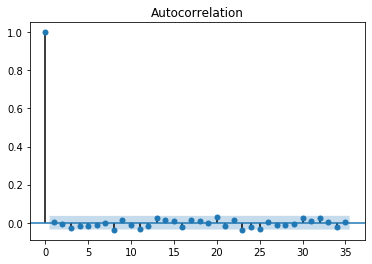

In [17]:
# Evaluate autocorrelation function
plot_acf(lin_model_fit['beta0'])
plot_acf(lin_model_fit['beta1'])
plot_acf(lin_model_fit['beta2'])
plot_acf(lin_model_fit['beta3'])
plot_acf(lin_model_fit['v'])

In [72]:
# A standard approach to checking the performance of a linear model fit is to compute "Studentised residuals".
# First we compute the fitted values at each point for each iteration of the chain.
fittedvalues=np.empty((len(lin_model_fit['beta0']),len(datatable['drat'])))
for i in range(len(lin_model_fit['beta0'])):
    fittedvalues[i,]=lin_model_fit['beta0'][i]+lin_model_fit['beta1'][i]*datatable['drat']+lin_model_fit['beta2'][i]*datatable['wt']+lin_model_fit['beta3'][i]*datatable['qsec']

# Now we compute the variance matrix for the estimates
XT=np.array(np.concatenate(([np.ones(len(datatable['drat']))],[datatable['drat']],[datatable['wt']],[datatable['qsec']])))
X=XT.transpose()
H=(X @ inv(XT @ X))@XT

# Compute studentised residuals
studentres=np.empty((len(lin_model_fit['beta0']),len(datatable['drat'])))
for i in range(len(lin_model_fit['beta0'])):
    studentres[i,]=(datatable['mpg']-fittedvalues[i,])/(np.sqrt((lin_model_fit['v'][i])*(1-np.diagonal(H))))

# Compute mean over posterior of studentised residuial at each data point
studentisedresm=np.empty(len(datatable['mpg']))
fittedvaluesm=np.empty(len(datatable['mpg']))

for i in range(len(datatable['mpg'])):
    studentisedresm[i]=np.mean(studentres[:,i])
    fittedvaluesm[i]=np.mean(fittedvalues[:,i])

((array([-2.02511189, -1.62590278, -1.38593914, -1.20666642, -1.05953591,
         -0.93235918, -0.81872017, -0.71478609, -0.6180591 , -0.52680137,
         -0.43973827, -0.35589149, -0.27447843, -0.19484777, -0.11643566,
         -0.03873405,  0.03873405,  0.11643566,  0.19484777,  0.27447843,
          0.35589149,  0.43973827,  0.52680137,  0.6180591 ,  0.71478609,
          0.81872017,  0.93235918,  1.05953591,  1.20666642,  1.38593914,
          1.62590278,  2.02511189]),
  array([-1.68225016, -1.42324982, -1.17819908, -1.06007525, -1.03809301,
         -0.94945462, -0.8903695 , -0.81703262, -0.77420503, -0.67319782,
         -0.6719594 , -0.37421726, -0.37375263, -0.35514337, -0.13988645,
         -0.12561188, -0.09247089, -0.04900894,  0.07287449,  0.16252374,
          0.2348004 ,  0.27033879,  0.36309112,  0.41952838,  0.46002453,
          0.54334554,  0.78612071,  1.40187576,  1.52833098,  1.95773698,
          2.16792434,  2.21708557])),
 (1.0294145072927874, -0.002580512807

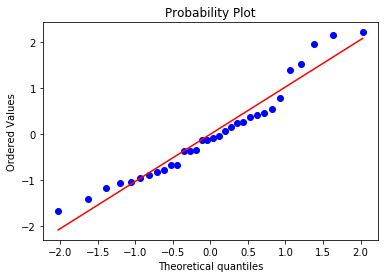

In [71]:
# Produce QQ plot. We are looking for this to be a diagonal line
stats.probplot(studentisedresm,plot=plt)

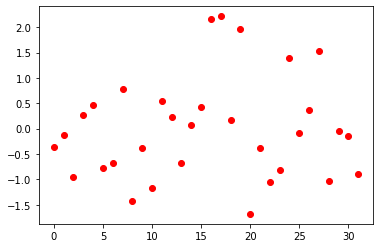

In [79]:
# Plot residuals versus index. These values should be not too farfrom zero and show no trends.
plt.plot(studentisedresm,'ro')

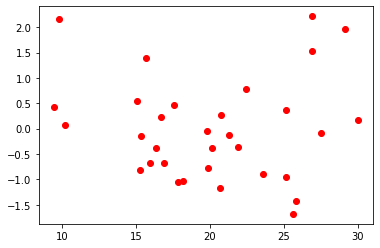

In [80]:
# Plot residuals versus fitted value. Again we are looking for the absence of trends
plt.plot(fittedvaluesm,studentisedresm,'ro')

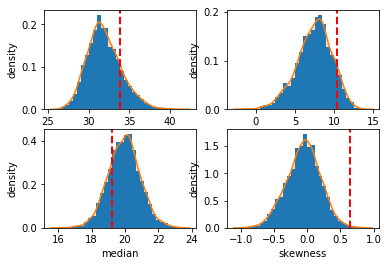

In [8]:
# Do predictive checks
preddist=lin_model_fit.extract('ypred')['ypred']
maxdist=np.amax(preddist,axis=1)
mindist=np.amin(preddist,axis=1)
mediandist=np.median(preddist,axis=1)
skewdist=stats.skew(preddist,axis=1)

plt.subplot(2,2,1)
plt.hist(maxdist, 30, density=True); sns.kdeplot(maxdist, shade=True)
plt.xlabel('maximum')
plt.ylabel('density')
plt.axvline(np.amax(datatable['mpg']), color='r', lw=2, linestyle='--',label='Observed value')

plt.subplot(2,2,2)
plt.hist(mindist, 30, density=True); sns.kdeplot(mindist, shade=True)
plt.xlabel('minimum')
plt.ylabel('density')
plt.axvline(np.amin(datatable['mpg']), color='r', lw=2, linestyle='--',label='Observed value')

plt.subplot(2,2,3)
plt.hist(mediandist, 30, density=True); sns.kdeplot(mediandist, shade=True)
plt.xlabel('median')
plt.ylabel('density')
plt.axvline(np.median(datatable['mpg']), color='r', lw=2, linestyle='--',label='Observed value')

plt.subplot(2,2,4)
plt.hist(skewdist, 30, density=True); sns.kdeplot(skewdist, shade=True)
plt.xlabel('skewness')
plt.ylabel('density')
plt.axvline(stats.skew(datatable['mpg']), color='r', lw=2, linestyle='--',label='Observed value')



In [11]:
# Robust regression
# Change model to do robust regression by using a student-t distribution.
lin_model_robust_def = """
data {
  int npts;
  vector[npts] mpg;
  vector[npts] drat;
  vector[npts] wt;
  vector[npts] qsec;
  real mu0;
  real var0;
  real a;
  real b;
  real c;
  real d;
}

parameters {
  real beta0;
  real beta1;
  real beta2;
  real beta3;
  real<lower=0> v;
  real<lower=0> nu;
}

model {
  for (i in 1:npts) {
        target+=student_t_lpdf(mpg[i] | nu, beta0+beta1*drat[i]+beta2*wt[i]+beta3*qsec[i], sqrt(v));
  }
  target += normal_lpdf(beta0 | mu0, sqrt(var0));
  target += normal_lpdf(beta1 | mu0, sqrt(var0));
  target += normal_lpdf(beta2 | mu0, sqrt(var0));
  target += normal_lpdf(beta3 | mu0, sqrt(var0));
  target += inv_gamma_lpdf(v | a,b);
  target += gamma_lpdf(nu |c,d);
}

generated quantities {
  vector[npts] ypred;
  for (i in 1:npts) {
    ypred[i]=student_t_rng(nu,beta0+beta1*drat[i]+beta2*wt[i]+beta3*qsec[i],sqrt(v));
  }
}
"""
lin_model_robust = pystan.StanModel(model_code=lin_model_robust_def)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_348a1eed051c18f7adeff670410aae08 NOW.


Inference for Stan model: anon_model_348a1eed051c18f7adeff670410aae08.
4 chains, each with iter=1000; warmup=250; thin=1; 
post-warmup draws per chain=750, total post-warmup draws=3000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta0      11.83    0.25   8.07  -4.92   6.66  12.09  17.29  26.62 1027.0    1.0
beta1       1.52    0.03   1.17  -0.83   0.72   1.54   2.29   3.86 1175.0    1.0
beta2       -4.4    0.02   0.73  -5.83  -4.91  -4.37  -3.91  -2.94 1105.0    1.0
beta3       0.94  6.8e-3   0.26   0.42   0.76   0.94   1.11   1.46 1509.0    1.0
v            5.0    0.05   1.96   2.05   3.59   4.72   6.08   9.47 1442.0    1.0
nu          7.72    0.19   6.52   1.64   3.44   5.63   9.69  25.88 1179.0    1.0
ypred[0]    21.8    0.14   7.85  15.51   20.1   21.7  23.34  27.55 2997.0    1.0
ypred[1]   21.08    0.06   3.48  15.16   19.4  21.12  22.78   27.0 3000.0    1.0
ypred[2]   24.93    0.08   4.14  18.58  23.26  24.94  26.59  31.01 2742.0    1.0
ypr

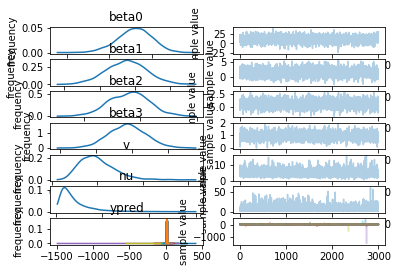

In [12]:
# Specify prior hyperparameters
# Priors on linear model coefficients.
mu0=0.
var0=1000.

# Prior on precision
a=0.1
b=0.1

# Prior on degrees of freedom
c=0.1
d=0.1

# Define data array
lin_model_robust_data = {'npts': datatable['mpg'][:].shape[0],
            'mpg': datatable['mpg'][:],
            'drat': datatable['drat'][:],
            'wt': datatable['wt'][:],'qsec': datatable['qsec'][:], 'mu0': mu0, 'var0': var0, 'a': a, 'b': b, 'c': c, 'd': d}


# Now get some samples from the posterior
lin_model_robust_fit = lin_model_robust.sampling(data=lin_model_robust_data, iter=1000, chains=4, warmup=250, thin=1, seed=101)

# Plot results 
lin_model_robust_fit.plot()
# Get summary statistics. Note summary automatically includes estimates of the effective sample size (n_eff) and the Gelman-Rubin 
# convergence diagnostic (Rhat).
lin_model_robust_fit

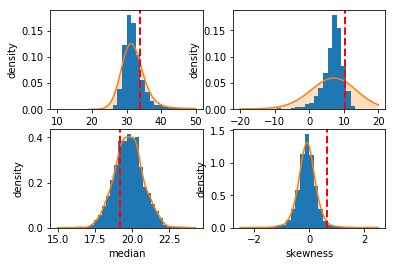

In [26]:
# Do predictive checks for the robust model
preddist=lin_model_robust_fit.extract('ypred')['ypred']
maxdist=np.amax(preddist,axis=1)
mindist=np.amin(preddist,axis=1)
mediandist=np.median(preddist,axis=1)
skewdist=stats.skew(preddist,axis=1)

plt.subplot(2,2,1)
plt.hist(maxdist, 30, density=True,range=(10,50)); sns.kdeplot(maxdist, shade=True,clip=(10,50))
plt.xlabel('maximum')
plt.ylabel('density')
plt.axvline(np.amax(datatable['mpg']), color='r', lw=2, linestyle='--',label='Observed value')

plt.subplot(2,2,2)
plt.hist(mindist, 30, density=True,range=(-20,20)); sns.kdeplot(mindist, shade=True,clip=(-20,20))
plt.xlabel('minimum')
plt.ylabel('density')
plt.axvline(np.amin(datatable['mpg']), color='r', lw=2, linestyle='--',label='Observed value')

plt.subplot(2,2,3)
plt.hist(mediandist, 30, density=True); sns.kdeplot(mediandist, shade=True)
plt.xlabel('median')
plt.ylabel('density')
plt.axvline(np.median(datatable['mpg']), color='r', lw=2, linestyle='--',label='Observed value')

plt.subplot(2,2,4)
plt.hist(skewdist, 30, density=True,range=(-2.5,2.5)); sns.kdeplot(skewdist, shade=True,clip=(-2.5,2.5))
plt.xlabel('skewness')
plt.ylabel('density')
plt.axvline(stats.skew(datatable['mpg']), color='r', lw=2, linestyle='--',label='Observed value')


# Exercises

In [ ]:
# Here are some quesitons for you to answer using the techniques introduced above.

In [ ]:
# Q1: Use the method of inversion to draw samples from the Cauchy distribution with location parameter
#     x0 = 1 and scale parameter gamma = 2.

In [ ]:
# Q2: Draw samples from a Gamma(2,0.5) distribution using rejection sampling. Start by using an Exp(0.25)
#     distribution as the sampling distribution. In that case you should set M = 4/e = 1.4715 (prove this!).
#     Can you make the algorithm more efficient by using a different rate parameter?

In [ ]:
# Q3: Newton's law of cooling. The following data are measurements of the temperature of a bore after 
#     that bore had been rubbed inside “a stationary cylinder and pressed against the bottom by means 
#     of a screw”. The bore was turned by a team of horses (this is an experiment with friction from 
#     1798 by a Count Rumford).

elapsedtime=[4,5,7,12,14,16,20,24,28,31,34,37.5,41]
temp=[126,125,123,120,119,118,116,115,114,113,112,111,110]

#     Newton's Law of Cooling sugests that the temperature should vary with time according to
#              temp = 60 + 70 exp(- theta * time)
#     Assuming that the errors in the observations are normally distributed with unknown variance 
#     sigma^2, use pystan to produce a Bayesian fit of this model to the data. Use an exponential prior
#     on theta since it is constrained to be positive. First fit a model in which the coefficients in
#     the model are fixed to be 60 and 70, and then try fitting a model in which these are taken to be 
#     unknown. In the latter case, again use exponential priors on the unknown coefficients.

In [ ]:
# Q4: Fitting a hierarchical model. The folllowing array is a set of observations of the log-concentration
#     of a chemical, made at a total of 6 different sites. 10 observations were taken at each site and
#     obs[i,j] gives the value of the j'th observation made at the i'th site. Observations are believed
#     to be normally distributed at each site, with different means and variances at each site. Fit a 
#     hierarchical model to this data. For the population model, assume that the means in each site
#     are drawn a Normal distribution and the variances from an inverse-Gamma distribution.

obs=[[12.74786302, 12.68007552, 11.67505642, 11.04218918, 11.35987204,
        11.29632211, 11.03908066, 11.97800934, 12.04914235, 12.34149684],
       [ 6.73465458,  6.33937286,  6.4254122 ,  6.64118285,  5.93518065,
         6.12205802,  6.61622889,  6.1457425 ,  6.21569553,  6.52305079],
       [12.53758243, 11.52837076, 10.87724228, 10.63150609, 11.09817623,
        13.43648394,  8.08939421, 11.74314854, 11.44286981, 12.07302458],
       [ 1.00855854,  2.39449993,  1.92152452,  1.47448063,  1.5642    ,
         1.19205148,  1.51778404,  1.43543178,  1.89715474,  1.64824989],
       [13.74200484, 13.95829032, 13.9237003 , 13.82899253, 13.3313036 ,
        14.05813043, 13.43436038, 13.47888067, 13.73580576, 13.9111883 ],
       [ 4.93995522, -0.8069532 ,  5.05785973,  5.36462075,  1.4697758 ,
         1.95254775,  1.26476869,  1.20631907, -0.16029252, -0.81058577]]